In [2]:
%cd ~/dev/event-camera/src

/home/gianscarpe/dev/event-camera/src


In [4]:
from experimenting.dataset.factory import Joints3DConstructor

from matplotlib import pyplot as plt
import numpy as np
from albumentations import Compose, CenterCrop
from albumentations.pytorch import ToTensor
import torch
from importlib import reload  
from experimenting.models import metrics, losses

from omegaconf import DictConfig

from experimenting.utils import get_file_paths, plot_heatmap, plot_skeleton_3d, denormalize_predict
import numpy as np
import glob
import os

%matplotlib inline

In [94]:
aug = Compose([CenterCrop(256, 256), ToTensor()])
homedir = '/data/gscarpellini/dhp19'

data_dir = os.path.join(homedir, 'voxel_grid_dataset/movements_per_frame')
labels_dir = os.path.join(homedir,"voxel_grid_dataset/labels_full_joints/")
exp_dir = '/home/gianscarpe/dev/exps/timecount_pose/exps_MargiPoseModel'
test_subjects = [1, 2, 3, 4, 5]
cams = [3]

batch_size = 16

hparams = DictConfig({'dataset':{'data_dir': data_dir, 'core_class': 'DHP19Core', 'save_split':False, 'hm_dir': labels_dir,'joints_dir' :
                      labels_dir, 'test_subjects':test_subjects, 'split_at':0.8, 'cams': cams}, 
                       'augmentation_test': {'info':{'in_shape':[260, 346]}, 'apply':{'aug_1': {'cls': 'albumentations.pytorch.ToTensor'}}},
                      'augmentation_train': {'info':{'in_shape':[260, 346]}, 'apply':{'aug_1': {'cls': 'albumentations.pytorch.ToTensor'}}}
                     })

In [95]:
factory = Joints3DConstructor(hparams)

.npy|.mat


In [96]:
_, _, test = factory.get_datasets()

In [97]:

loader = get_dataloader(test, batch_size, shuffle=False, num_workers=2)

In [98]:
batch = next(iter(loader))
x, y = batch

In [146]:
x.shape

torch.Size([16, 4, 260, 346])

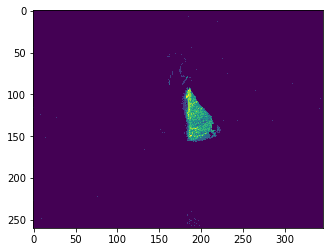

In [152]:
plt.imshow(np.squeeze(x[0, 3].numpy()))

 # Eval margipose model

In [46]:
exps = sorted(glob.glob(os.path.join(exp_dir,'exp*')))
print(list(exps))

['/home/gianscarpe/dev/exps/timecount_pose/exps_MargiPoseModel/exp_Adam_0.0003_center_crop_06-16-10-20', '/home/gianscarpe/dev/exps/timecount_pose/exps_MargiPoseModel/exp_Adam_0.0003_center_crop_06-17-09-33', '/home/gianscarpe/dev/exps/timecount_pose/exps_MargiPoseModel/exp_Adam_0.0003_center_crop_06-22-13-57', '/home/gianscarpe/dev/exps/timecount_pose/exps_MargiPoseModel/exp_Adam_0.0003_center_crop_06-22-14-50', '/home/gianscarpe/dev/exps/timecount_pose/exps_MargiPoseModel/exp_Adam_0.0003_center_crop_06-22-15-11', '/home/gianscarpe/dev/exps/timecount_pose/exps_MargiPoseModel/exp_Adam_0.0003_center_crop_06-22-15-14', '/home/gianscarpe/dev/exps/timecount_pose/exps_MargiPoseModel/exp_Adam_0.0003_center_crop_06-23-11-07', '/home/gianscarpe/dev/exps/timecount_pose/exps_MargiPoseModel/exp_Adam_0.0003_center_crop_06-26-12-11', '/home/gianscarpe/dev/exps/timecount_pose/exps_MargiPoseModel/exp_Adam_0.0003_center_crop_06-29-16-24', '/home/gianscarpe/dev/exps/timecount_pose/exps_MargiPoseModel/e

In [100]:
import experimenting.agents as agents
import os
import experimenting.models.metrics as metrics
import experimenting.models.losses as losses
from experimenting.utils import get_joints_from_heatmap, average_loss, decompose_projection_matrix, plot_skeleton_3d, reproject_skeleton
import experimenting.utils.cv_helpers as utils


exp_name = "/home/gianscarpe/dev/exps/voxelgrid/exps_MargiposeEstimator/08-28-09-18_exp_resnet34_pretrained_False_08-28-09-18"
checkpoint_dir = os.path.join(exp_name, 'checkpoints')
checkpoints = sorted(os.listdir(checkpoint_dir))
checkpoint_path = os.path.join(checkpoint_dir, checkpoints[0])
model = agents.MargiposeEstimator.load_from_checkpoint(checkpoint_path)
model = model.cpu()

In [101]:
checkpoint_path

'/home/gianscarpe/dev/exps/voxelgrid/exps_MargiposeEstimator/08-28-09-18_exp_resnet34_pretrained_False_08-28-09-18/checkpoints/epoch=16-val_loss=0.11.ckpt'

In [58]:
# Load matrix

P_mat_dir = os.path.join(homedir, 'P_matrices/')
P_mat_cam3 = np.load(os.path.join(P_mat_dir,'P2.npy'))
M,_ = decompose_projection_matrix(P_mat_cam3)


In [171]:
preds[0][-1].shape

torch.Size([1, 13, 33, 44])

XY GT


TypeError: Invalid shape (346,) for image data

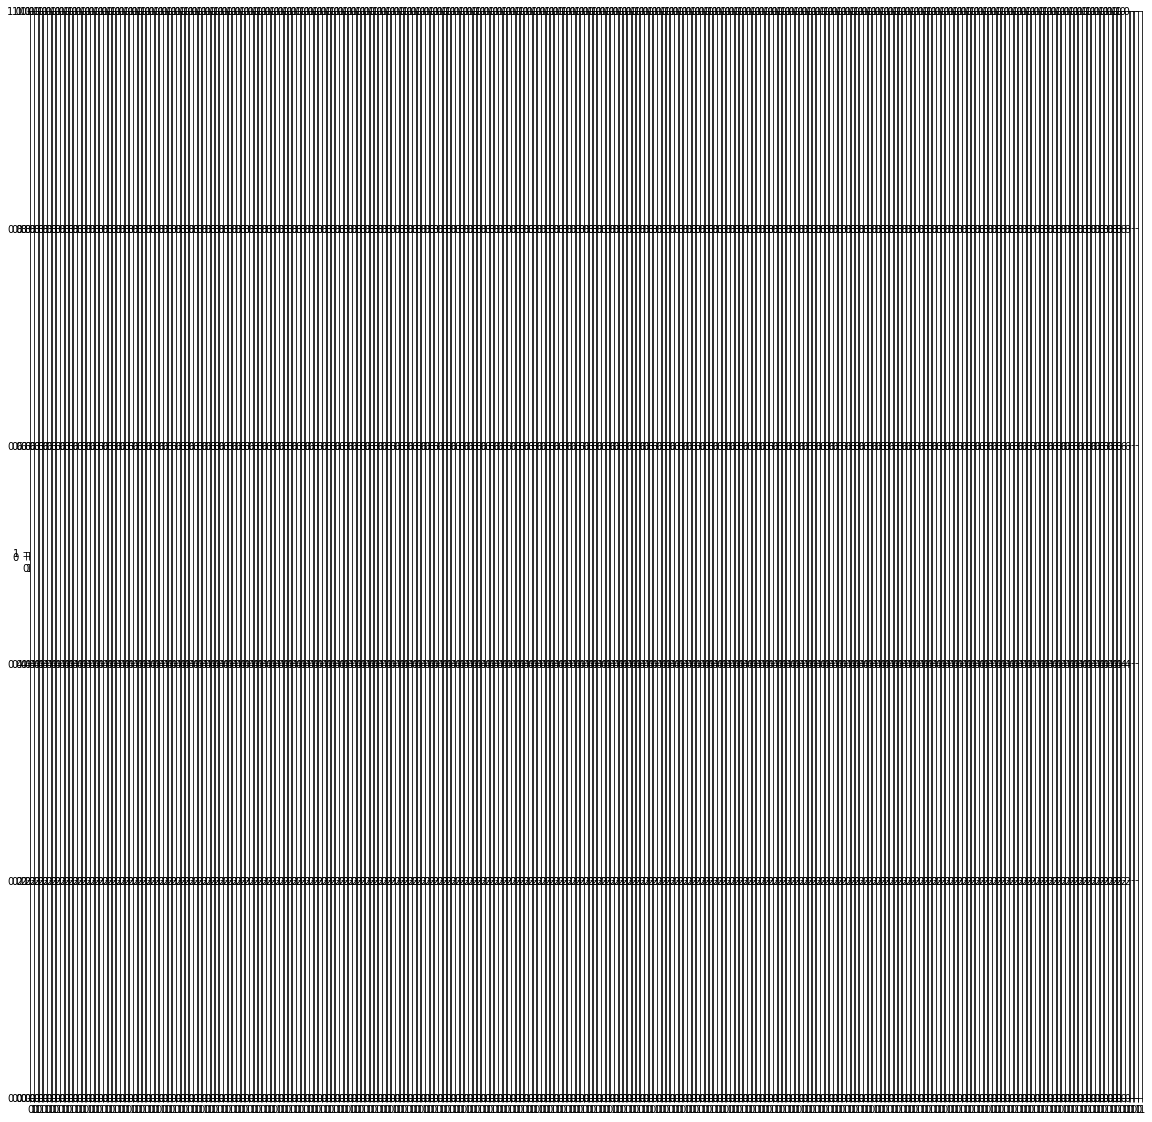

In [166]:
idx = 0

y_sample = np.load(test.dataset.joints[test.x_indexes[0]])
x_sample, _ = test[idx]

with torch.no_grad():
    preds = model(x_sample.unsqueeze(0))

#plt.imshow(x_sample.squeeze())

# XY
print("PRED XY")
plot_heatmap(preds[0][-1][0])

# ZY
print("PRED ZY")
plot_heatmap(preds[1][-1][0])

# XZ
print("PRED XZ")
plot_heatmap(preds[2][-1][0])


TypeError: Invalid shape (4, 260, 346) for image data

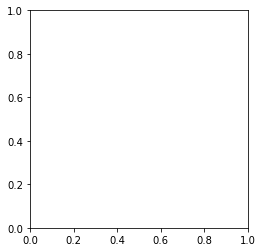

In [103]:
plt.imshow(np.squeeze(x[0].numpy()))

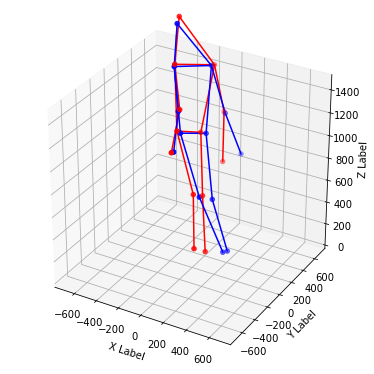

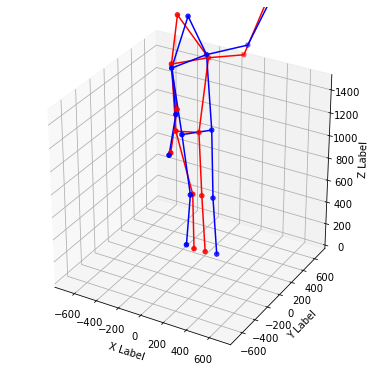

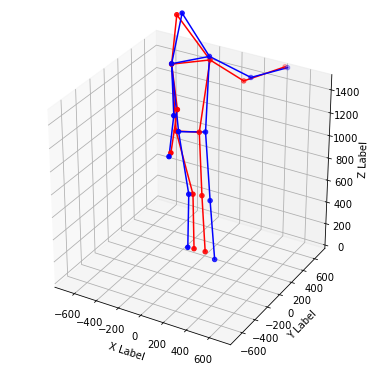

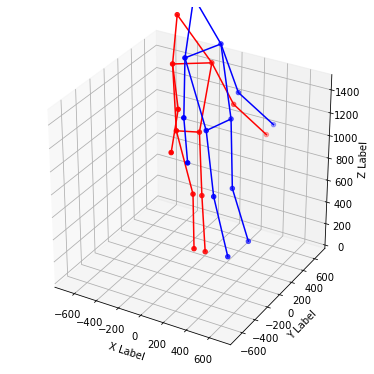

In [157]:
with torch.no_grad():
    preds = model(x.cpu())
    normalized_skeletons = model.predict3d(preds)
    
reload(utils)
for i in range(4):
    camera = y['camera'][i]
    M = y['M'][i]
    gt_skeleton = y['skeleton'][i]
    pred_skeleton = normalized_skeletons[i].narrow(-1, 0, 3)
    pred_skeleton = utils.denormalize_predict(pred_skeleton,
                                        260, 346, camera)
    utils.plot_skeleton_3d(gt_skeleton.numpy(), pred_skeleton.numpy().swapaxes(1, 0), M)


# Test video 

In [56]:
import glob
import numpy as np
import h5py

In [61]:
root_dir = "/data/dhp19/time_count_dataset/346x260/"

x_paths = sorted(glob.glob(os.path.join(root_dir, "S1_*events.h5")))

In [63]:
x_h5 = h5py.File(x_paths[0], 'r')

In [67]:
frames = x_h5['DVS'][..., 2]

In [94]:
M, K = decompose_projection_matrix(P_mat_cam3)
K = torch.tensor(K)

In [98]:
with torch.no_grad():
    for i in range(len(frames)):
        f = frames[i] / 255.
        f = f.swapaxes(0, 1)
        augmented = aug(image=f)
        x = augmented['image'].unsqueeze(0).unsqueeze(0)

        preds = model(x.cpu())
        normalized_skeletons = model.predict3d(preds)

        pred_skeleton = normalized_skeletons[0].narrow(-1, 0, 3)
        pred_skeleton = utils.denormalize_predict(pred_skeleton,
                                                  256, 256, K)
        utils.plot_skeleton_3d(pred_skeleton, pred_skeleton, M)
        plt.savefig(f'test{i}.png')
        plt.close()


In [100]:
import cv2

In [ ]:
fe

In [ ]:
writer = cv2.VideoWriter("input.avi", cv2.VideoWriter_fourcc(*"MJPG"), 3,
                      (346, 260))
for im in frames:
        f = im.swapaxes(0, 1)
        f = np.expand_dims(f, -1)
        f = np.concatenate([f, f, f], axis=-1)
        writer.write(f.astype('uint8'))
writer.release()



In [ ]:
writer = cv2.VideoWriter("pred.avi", cv2.VideoWriter_fourcc(*"MJPG"), 3,
                         (360, 360))
images = sorted(glob.glob("*.png"))
for frame in images:
    im = cv2.imread(frame)
    writer.write(im.astype('uint8'))
writer.release()

